# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

In [ ]:
d9db2ff4ef3666cdba0d6ba9771c6ed07ed8376cf5e4e5de

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

from torch.autograd import Variable


class conv2DBatchNorm(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cb_unit = nn.Sequential(conv_mod, nn.BatchNorm2d(int(n_filters)))
        else:
            self.cb_unit = nn.Sequential(conv_mod)

    def forward(self, inputs):
        outputs = self.cb_unit(inputs)
        return outputs


class conv2DGroupNorm(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cg_unit = nn.Sequential(conv_mod, nn.GroupNorm(n_groups, int(n_filters)))

    def forward(self, inputs):
        outputs = self.cg_unit(inputs)
        return outputs


class deconv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNorm, self).__init__()

        self.dcb_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
        )

    def forward(self, inputs):
        outputs = self.dcb_unit(inputs)
        return outputs


class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class conv2DGroupNormRelu(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cgr_unit = nn.Sequential(
            conv_mod, nn.GroupNorm(n_groups, int(n_filters)), nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        outputs = self.cgr_unit(inputs)
        return outputs


class deconv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNormRelu, self).__init__()

        self.dcbr_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs):
        outputs = self.dcbr_unit(inputs)
        return outputs


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm):
        super(unetConv2, self).__init__()

        if is_batchnorm:
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_size, out_size, 3, 1, 0), nn.BatchNorm2d(out_size), nn.ReLU()
            )
        else:
            self.conv1 = nn.Sequential(nn.Conv2d(in_size, out_size, 3, 1, 0), nn.ReLU())
            self.conv2 = nn.Sequential(nn.Conv2d(out_size, out_size, 3, 1, 0), nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs


class residualBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBlock, self).__init__()

        self.convbnrelu1 = conv2DBatchNormRelu(in_channels, n_filters, 3, stride, 1, bias=False)
        self.convbn2 = conv2DBatchNorm(n_filters, n_filters, 3, 1, 1, bias=False)
        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        out = self.convbnrelu1(x)
        out = self.convbn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out


class residualBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, n_filters, stride=1, downsample=None):
        super(residualBottleneck, self).__init__()
        self.convbn1 = nn.Conv2DBatchNorm(in_channels, n_filters, k_size=1, bias=False)
        self.convbn2 = nn.Conv2DBatchNorm(
            n_filters, n_filters, k_size=3, padding=1, stride=stride, bias=False
        )
        self.convbn3 = nn.Conv2DBatchNorm(n_filters, n_filters * 4, k_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.convbn1(x)
        out = self.convbn2(out)
        out = self.convbn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class linknetUp(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(linknetUp, self).__init__()

        # B, 2C, H, W -> B, C/2, H, W
        self.convbnrelu1 = conv2DBatchNormRelu(
            in_channels, n_filters / 2, k_size=1, stride=1, padding=1
        )

        # B, C/2, H, W -> B, C/2, H, W
        self.deconvbnrelu2 = nn.deconv2DBatchNormRelu(
            n_filters / 2, n_filters / 2, k_size=3, stride=2, padding=0
        )

        # B, C/2, H, W -> B, C, H, W
        self.convbnrelu3 = conv2DBatchNormRelu(
            n_filters / 2, n_filters, k_size=1, stride=1, padding=1
        )

    def forward(self, x):
        x = self.convbnrelu1(x)
        x = self.deconvbnrelu2(x)
        x = self.convbnrelu3(x)
        return x


class FRRU(nn.Module):
    """
    Full Resolution Residual Unit for FRRN
    """

    def __init__(self, prev_channels, out_channels, scale, group_norm=False, n_groups=None):
        super(FRRU, self).__init__()
        self.scale = scale
        self.prev_channels = prev_channels
        self.out_channels = out_channels
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            conv_unit = conv2DGroupNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv_unit(
                out_channels,
                out_channels,
                k_size=3,
                stride=1,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            conv_unit = conv2DBatchNormRelu
            self.conv1 = conv_unit(
                prev_channels + 32, out_channels, k_size=3, stride=1, padding=1, bias=False
            )
            self.conv2 = conv_unit(
                out_channels, out_channels, k_size=3, stride=1, padding=1, bias=False
            )

        self.conv_res = nn.Conv2d(out_channels, 32, kernel_size=1, stride=1, padding=0)

    def forward(self, y, z):
        x = torch.cat([y, nn.MaxPool2d(self.scale, self.scale)(z)], dim=1)
        y_prime = self.conv1(x)
        y_prime = self.conv2(y_prime)

        x = self.conv_res(y_prime)
        upsample_size = torch.Size([_s * self.scale for _s in y_prime.shape[-2:]])
        x = F.upsample(x, size=upsample_size, mode="nearest")
        z_prime = z + x

        return y_prime, z_prime


class RU(nn.Module):
    """
    Residual Unit for FRRN
    """

    def __init__(self, channels, kernel_size=3, strides=1, group_norm=False, n_groups=None):
        super(RU, self).__init__()
        self.group_norm = group_norm
        self.n_groups = n_groups

        if self.group_norm:
            self.conv1 = conv2DGroupNormRelu(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )
            self.conv2 = conv2DGroupNorm(
                channels,
                channels,
                k_size=kernel_size,
                stride=strides,
                padding=1,
                bias=False,
                n_groups=self.n_groups,
            )

        else:
            self.conv1 = conv2DBatchNormRelu(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )
            self.conv2 = conv2DBatchNorm(
                channels, channels, k_size=kernel_size, stride=strides, padding=1, bias=False
            )

    def forward(self, x):
        incoming = x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + incoming


class residualConvUnit(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(residualConvUnit, self).__init__()

        self.residual_conv_unit = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=kernel_size),
        )

    def forward(self, x):
        input = x
        x = self.residual_conv_unit(x)
        return x + input


class multiResolutionFusion(nn.Module):
    def __init__(self, channels, up_scale_high, up_scale_low, high_shape, low_shape):
        super(multiResolutionFusion, self).__init__()

        self.up_scale_high = up_scale_high
        self.up_scale_low = up_scale_low

        self.conv_high = nn.Conv2d(high_shape[1], channels, kernel_size=3)

        if low_shape is not None:
            self.conv_low = nn.Conv2d(low_shape[1], channels, kernel_size=3)

    def forward(self, x_high, x_low):
        high_upsampled = F.upsample(
            self.conv_high(x_high), scale_factor=self.up_scale_high, mode="bilinear"
        )

        if x_low is None:
            return high_upsampled

        low_upsampled = F.upsample(
            self.conv_low(x_low), scale_factor=self.up_scale_low, mode="bilinear"
        )

        return low_upsampled + high_upsampled


class chainedResidualPooling(nn.Module):
    def __init__(self, channels, input_shape):
        super(chainedResidualPooling, self).__init__()

        self.chained_residual_pooling = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.MaxPool2d(5, 1, 2),
            nn.Conv2d(input_shape[1], channels, kernel_size=3),
        )

    def forward(self, x):
        input = x
        x = self.chained_residual_pooling(x)
        return x + input


class pyramidPooling(nn.Module):
    def __init__(
        self, in_channels, pool_sizes, model_name="pspnet", fusion_mode="cat", is_batchnorm=True
    ):
        super(pyramidPooling, self).__init__()

        bias = not is_batchnorm

        self.paths = []
        for i in range(len(pool_sizes)):
            self.paths.append(
                conv2DBatchNormRelu(
                    in_channels,
                    int(in_channels / len(pool_sizes)),
                    1,
                    1,
                    0,
                    bias=bias,
                    is_batchnorm=is_batchnorm,
                )
            )

        self.path_module_list = nn.ModuleList(self.paths)
        self.pool_sizes = pool_sizes
        self.model_name = model_name
        self.fusion_mode = fusion_mode

    def forward(self, x):
        h, w = x.shape[2:]

        if self.training or self.model_name != "icnet":  # general settings or pspnet
            k_sizes = []
            strides = []
            for pool_size in self.pool_sizes:
                k_sizes.append((int(h / pool_size), int(w / pool_size)))
                strides.append((int(h / pool_size), int(w / pool_size)))
        else:  # eval mode and icnet: pre-trained for 1025 x 2049
            k_sizes = [(8, 15), (13, 25), (17, 33), (33, 65)]
            strides = [(5, 10), (10, 20), (16, 32), (33, 65)]

        if self.fusion_mode == "cat":  # pspnet: concat (including x)
            output_slices = [x]

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                output_slices.append(out)

            return torch.cat(output_slices, dim=1)
        else:  # icnet: element-wise sum (including x)
            pp_sum = x

            for i, (module, pool_size) in enumerate(zip(self.path_module_list, self.pool_sizes)):
                out = F.avg_pool2d(x, k_sizes[i], stride=strides[i], padding=0)
                # out = F.adaptive_avg_pool2d(x, output_size=(pool_size, pool_size))
                if self.model_name != "icnet":
                    out = module(out)
                out = F.interpolate(out, size=(h, w), mode="bilinear", align_corners=True)
                pp_sum = pp_sum + out

            return pp_sum


class bottleNeckPSP(nn.Module):
    def __init__(
        self, in_channels, mid_channels, out_channels, stride, dilation=1, is_batchnorm=True
    ):
        super(bottleNeckPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=stride,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, out_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        self.cb4 = conv2DBatchNorm(
            in_channels,
            out_channels,
            1,
            stride=stride,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x):
        conv = self.cb3(self.cbr2(self.cbr1(x)))
        residual = self.cb4(x)
        return F.relu(conv + residual, inplace=True)


class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation=1, is_batchnorm=True):
        super(bottleNeckIdentifyPSP, self).__init__()

        bias = not is_batchnorm

        self.cbr1 = conv2DBatchNormRelu(
            in_channels, mid_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )
        if dilation > 1:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=dilation,
                bias=bias,
                dilation=dilation,
                is_batchnorm=is_batchnorm,
            )
        else:
            self.cbr2 = conv2DBatchNormRelu(
                mid_channels,
                mid_channels,
                3,
                stride=1,
                padding=1,
                bias=bias,
                dilation=1,
                is_batchnorm=is_batchnorm,
            )
        self.cb3 = conv2DBatchNorm(
            mid_channels, in_channels, 1, stride=1, padding=0, bias=bias, is_batchnorm=is_batchnorm
        )

    def forward(self, x):
        residual = x
        x = self.cb3(self.cbr2(self.cbr1(x)))
        return F.relu(x + residual, inplace=True)


class residualBlockPSP(nn.Module):
    def __init__(
        self,
        n_blocks,
        in_channels,
        mid_channels,
        out_channels,
        stride,
        dilation=1,
        include_range="all",
        is_batchnorm=True,
    ):
        super(residualBlockPSP, self).__init__()

        if dilation > 1:
            stride = 1

        # residualBlockPSP = convBlockPSP + identityBlockPSPs
        layers = []
        if include_range in ["all", "conv"]:
            layers.append(
                bottleNeckPSP(
                    in_channels,
                    mid_channels,
                    out_channels,
                    stride,
                    dilation,
                    is_batchnorm=is_batchnorm,
                )
            )
        if include_range in ["all", "identity"]:
            for i in range(n_blocks - 1):
                layers.append(
                    bottleNeckIdentifyPSP(
                        out_channels, mid_channels, stride, dilation, is_batchnorm=is_batchnorm
                    )
                )

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class cascadeFeatureFusion(nn.Module):
    def __init__(
        self, n_classes, low_in_channels, high_in_channels, out_channels, is_batchnorm=True
    ):
        super(cascadeFeatureFusion, self).__init__()

        bias = not is_batchnorm

        self.low_dilated_conv_bn = conv2DBatchNorm(
            low_in_channels,
            out_channels,
            3,
            stride=1,
            padding=2,
            bias=bias,
            dilation=2,
            is_batchnorm=is_batchnorm,
        )
        self.low_classifier_conv = nn.Conv2d(
            int(low_in_channels),
            int(n_classes),
            kernel_size=1,
            padding=0,
            stride=1,
            bias=True,
            dilation=1,
        )  # Train only
        self.high_proj_conv_bn = conv2DBatchNorm(
            high_in_channels,
            out_channels,
            1,
            stride=1,
            padding=0,
            bias=bias,
            is_batchnorm=is_batchnorm,
        )

    def forward(self, x_low, x_high):
        x_low_upsampled = F.interpolate(
            x_low, size=get_interp_size(x_low, z_factor=2), mode="bilinear", align_corners=True
        )

        low_cls = self.low_classifier_conv(x_low_upsampled)

        low_fm = self.low_dilated_conv_bn(x_low_upsampled)
        high_fm = self.high_proj_conv_bn(x_high)
        high_fused_fm = F.relu(low_fm + high_fm, inplace=True)

        return high_fused_fm, low_cls


def get_interp_size(input, s_factor=1, z_factor=1):  # for caffe
    ori_h, ori_w = input.shape[2:]

    # shrink (s_factor >= 1)
    ori_h = (ori_h - 1) / s_factor + 1
    ori_w = (ori_w - 1) / s_factor + 1

    # zoom (z_factor >= 1)
    ori_h = ori_h + (ori_h - 1) * (z_factor - 1)
    ori_w = ori_w + (ori_w - 1) * (z_factor - 1)

    resize_shape = (int(ori_h), int(ori_w))
    return resize_shape


def interp(input, output_size, mode="bilinear"):
    n, c, ih, iw = input.shape
    oh, ow = output_size

    # normalize to [-1, 1]
    h = torch.arange(0, oh, dtype=torch.float, device=input.device) / (oh - 1) * 2 - 1
    w = torch.arange(0, ow, dtype=torch.float, device=input.device) / (ow - 1) * 2 - 1

    grid = torch.zeros(oh, ow, 2, dtype=torch.float, device=input.device)
    grid[:, :, 0] = w.unsqueeze(0).repeat(oh, 1)
    grid[:, :, 1] = h.unsqueeze(0).repeat(ow, 1).transpose(0, 1)
    grid = grid.unsqueeze(0).repeat(n, 1, 1, 1)  # grid.shape: [n, oh, ow, 2]
    grid = Variable(grid)
    if input.is_cuda:
        grid = grid.cuda()

    return F.grid_sample(input, grid, mode=mode)


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()

In [4]:
torch.manual_seed(999)

In [5]:
import numpy as np
from PIL import Image


_errstr = "Mode is unknown or incompatible with input array shape."


def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

### 1.1 Loading the dataset

In [6]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms

from torchvision.transforms import ToTensor



class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        #lbl = ToTensor()(Image.open(lbl_path))
        lbl = Image.open(lbl_path)
        
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
            
        outputFeatures = []

        for i in range(21):
            outputFeatures.append((lbl == i).float())
        
        return im,torch.stack(outputFeatures)# torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]), Image.NEAREST)
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).int()
        lbl[lbl == 255] = 0
        return img, lbl

    @staticmethod
    def get_pascal_labels():
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    @staticmethod
    def encode_segmap(mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        
        mask = mask.astype(int)
        mask = mask[:, :, 0:3]
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(pascalVOCDataset.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    @staticmethod
    def decode_segmap(label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_mask = (label_mask * 255).long()
        label_colours = torch.from_numpy(pascalVOCDataset.get_pascal_labels()).to(torch.int16)
        r = torch.zeros(label_mask.shape, dtype=torch.int16)
        g = torch.zeros(label_mask.shape, dtype=torch.int16)
        b = torch.zeros(label_mask.shape, dtype=torch.int16)
        for ll in range(0, 21):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = torch.zeros((3, label_mask.shape[0], label_mask.shape[1]))
        rgb[0, :, :] = r
        rgb[1, :, :] = g
        rgb[2, :, :] = b

        rgb /= 255

        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = pascalVOCDataset.encode_segmap(imageio.imread(lbl_path))
                lbl = toimage(lbl, high=lbl.max(), low=lbl.min())
                imageio.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Segnet(nn.Module):
  
    def __init__(self):
        super(Segnet, self).__init__()
        self.conv1 = self.layer(3, 1, 3)
        self.conv2 = self.layer(1, 1, 3)
        self.conv3 = self.layer(1, 1, 3)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 5)
        #self.fc1 = nn.Linear(16 * 5 * 5, 120)
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        
        #self.lin = nn.Linear(200 * 200 * 3, 2)
        
    def layer(self, input, output, kernel):
        conv = nn.Conv2d(input, output, kernel, 1, kernel // 2 )
        relu = nn.Sequential(conv, nn.ReLU(inplace=True))
        
        return relu

    def forward(self, x):
        #x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, 16 * 5 * 5)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        #x = x.view(-1, self.num_flat_features(x))
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x
        #return self.lin(x)
    
    
    def num_flat_features(self, x):
        size = x.size()[0:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
            
        
        
        return num_features

    

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Segnet(nn.Module):
    def __init__(self):
        super(Segnet, self).__init__()


        self.down1 = segnetDown2(3, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512)

        self.up5 = segnetUp3(512, 512)
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, 21)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)

        up5 = self.up5(down5, indices_5, unpool_shape5)
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)

        return up1

In [8]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
model = Segnet().cuda()

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [10]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = None
epochs = 10


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [11]:
# dataset variable
dst = pascalVOCDataset(local_path, is_transform= True)

def wrap(tup):
    a,b = tup
    return (a.unsqueeze(0), b)

# dataloader variable
#trainloader = [wrap(dst[i]) for i in range(len(dst))]


bs = 1

trainloader = data.DataLoader(
        dst,
        batch_size=bs,
        #shuffle=True,
    )

In [12]:
'''inputs = []
targets = []

bs = 5

for i in range(len(dst)):
    batch = i // bs
    input, target = dst[i]
    
    if i % bs == 0:
        inputs.append([])
        targets.append([])
        
    inputs[batch].append(input)
    targets[batch].append(target)

batches = []
for i in range(len(inputs)):
    batches.append((torch.stack(inputs[i]), torch.stack(targets[i])))

'''

'inputs = []\ntargets = []\n\nbs = 5\n\nfor i in range(len(dst)):\n    batch = i // bs\n    input, target = dst[i]\n    \n    if i % bs == 0:\n        inputs.append([])\n        targets.append([])\n        \n    inputs[batch].append(input)\n    targets[batch].append(target)\n\nbatches = []\nfor i in range(len(inputs)):\n    batches.append((torch.stack(inputs[i]), torch.stack(targets[i])))\n\n'

In [13]:
dst[0][1].shape

torch.Size([21, 512, 512])

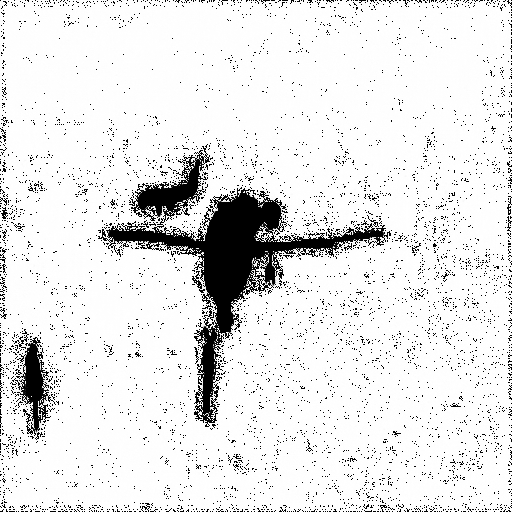

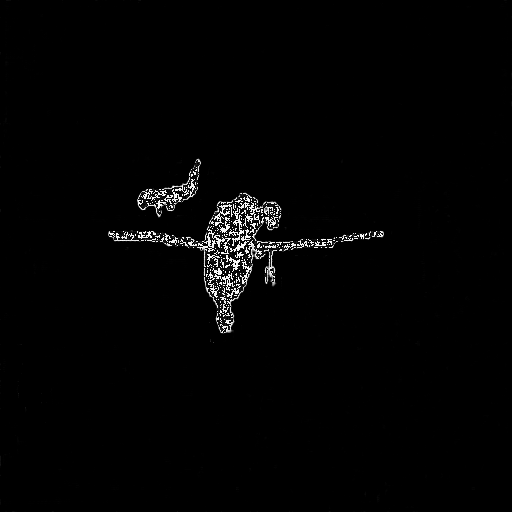

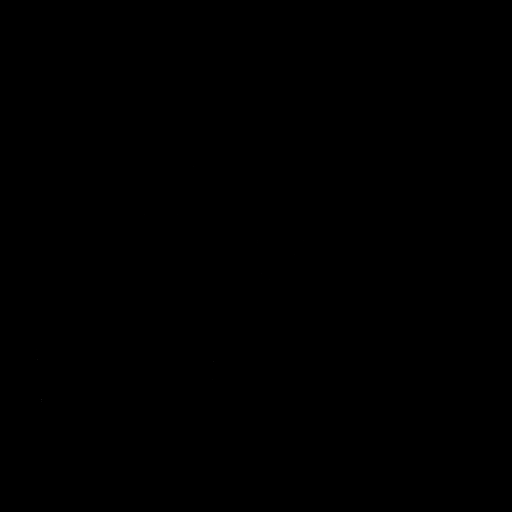

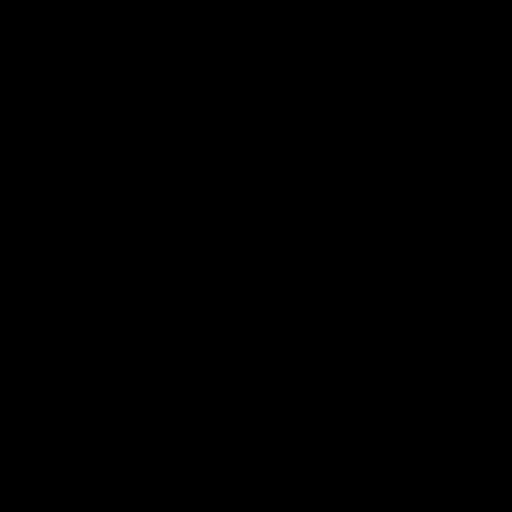

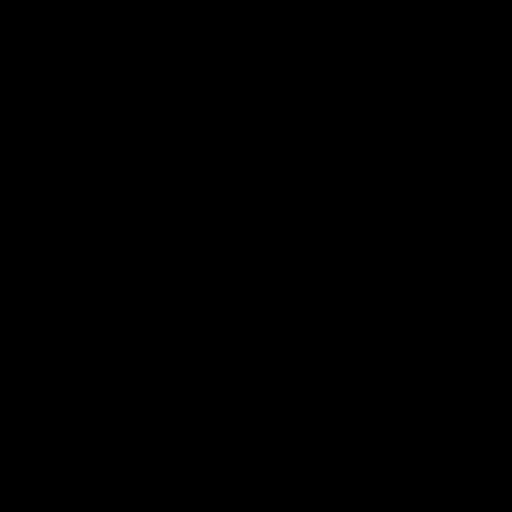

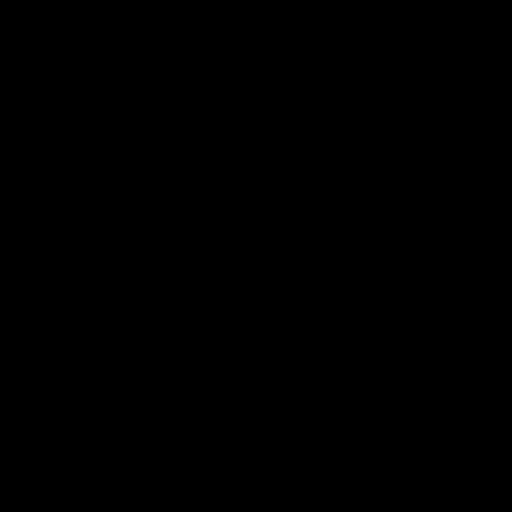

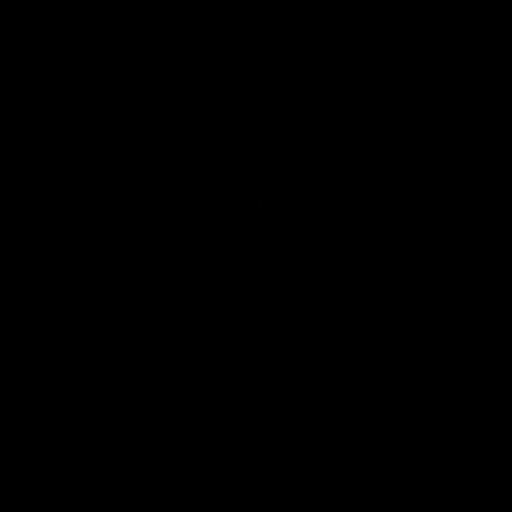

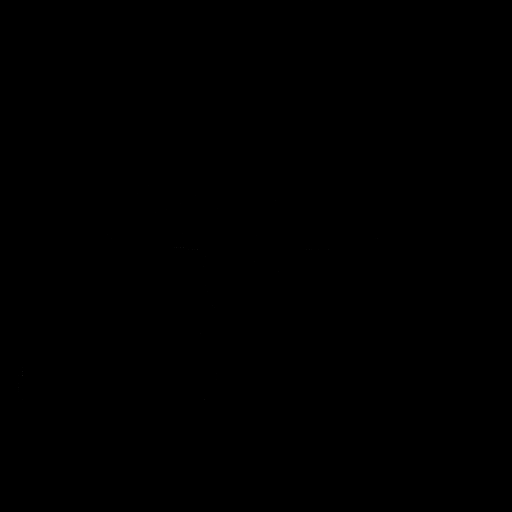

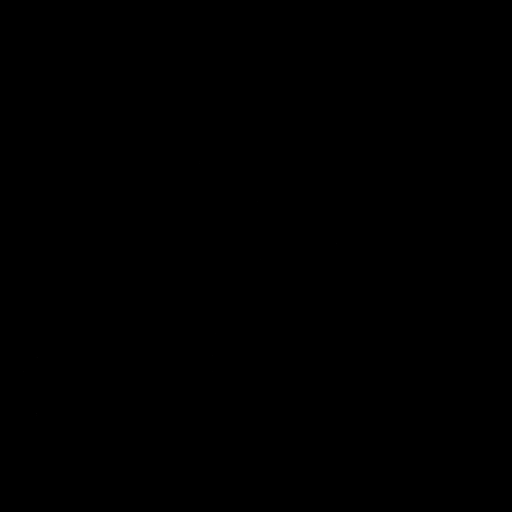

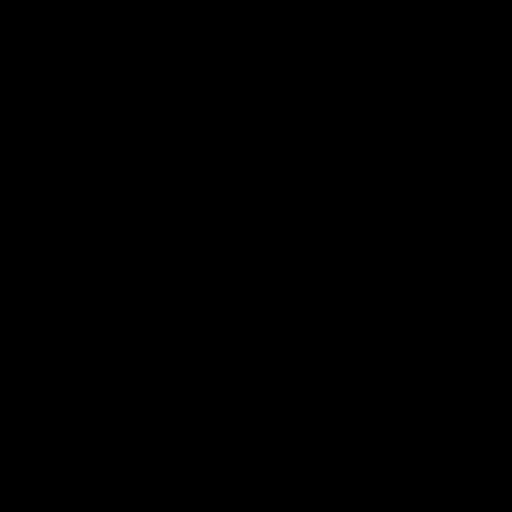

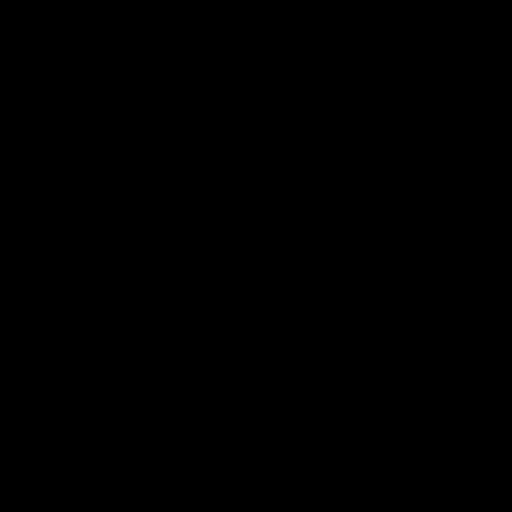

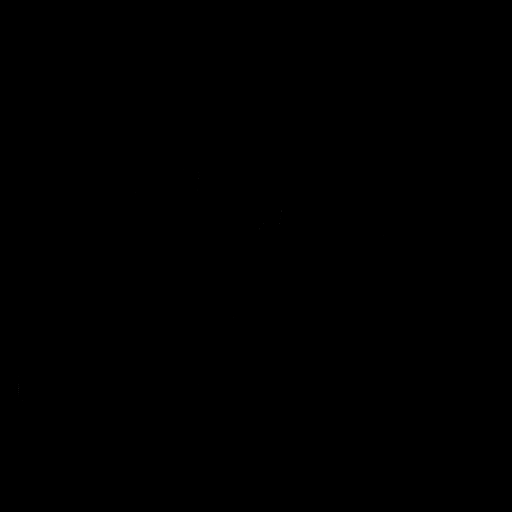

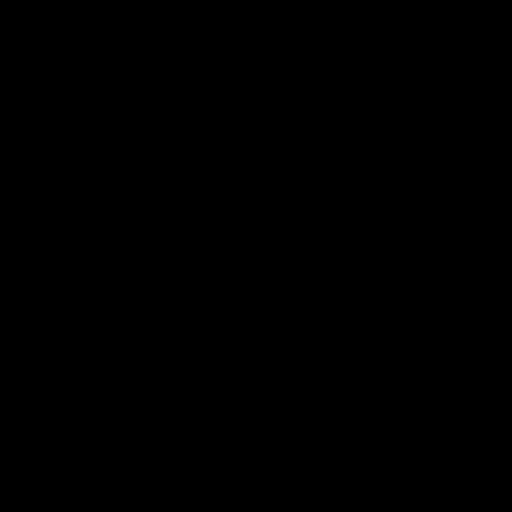

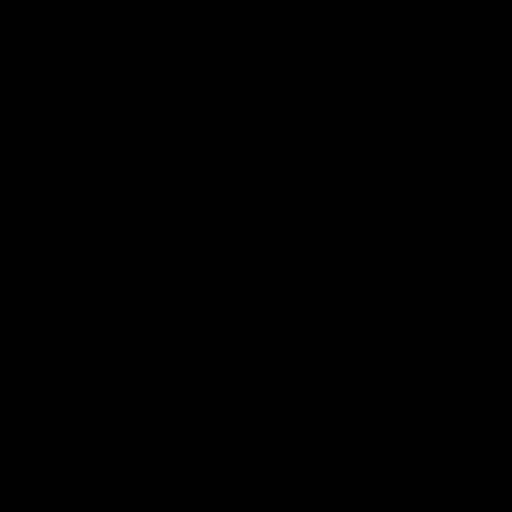

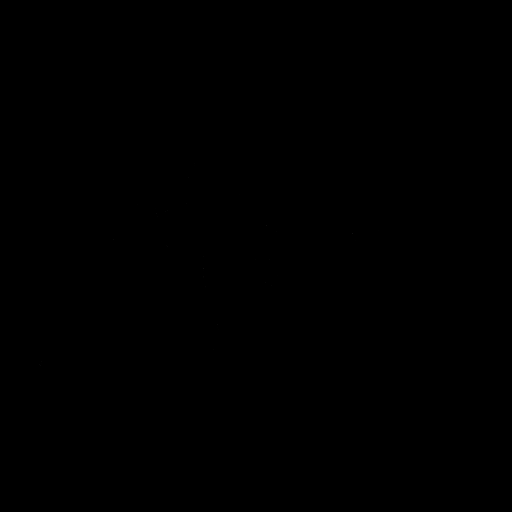

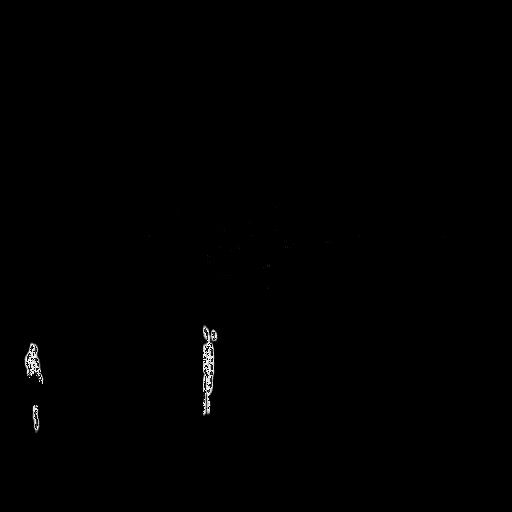

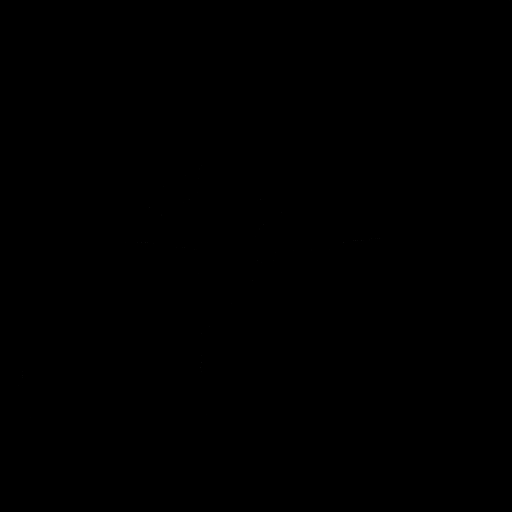

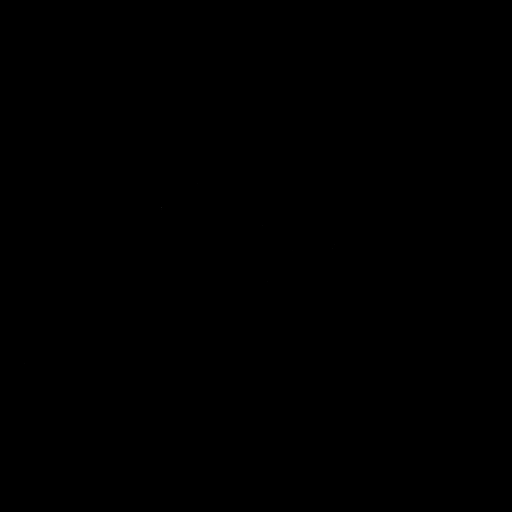

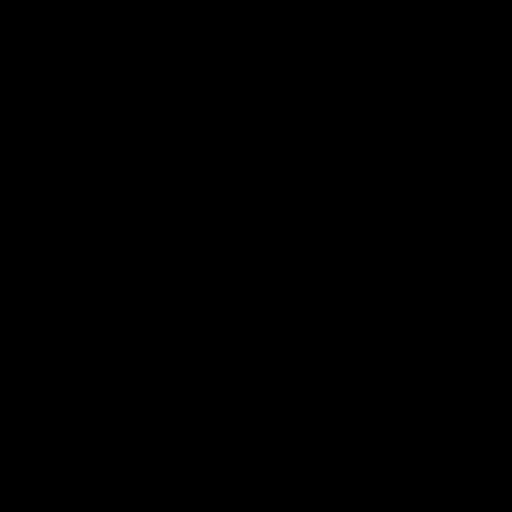

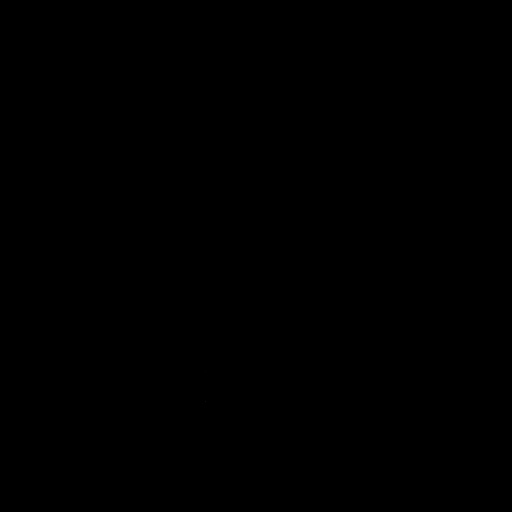

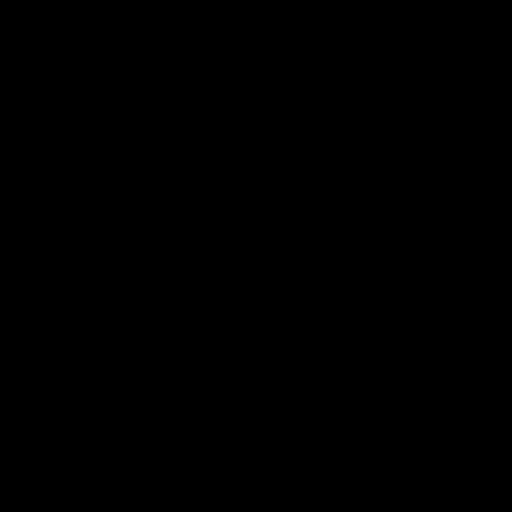

torch.Size([1, 21, 512, 512])

torch.Size([1, 3, 512, 512])

In [14]:
batch = dst[1]

input = batch[0]
target = batch[1]

for input, target in trainloader:
    modelInput = input
    modelOutput = model(input.cuda())
    #display(transforms.ToPILImage()(modelInput))
    for i in range(21):
        display(transforms.ToPILImage()(modelOutput[0][i].cpu()))
    break


#display(transforms.ToPILImage()((target == 0).float()))

#dst = pascalVOCDataset(local_path, is_transform= True)
#modelOutput = model(input.unsqueeze(0).cuda()).squeeze()
#modelOutput = model(input).squeeze()

'''target = pascalVOCDataset.decode_segmap(target)
output = pascalVOCDataset.decode_segmap(modelOutput )

display(transforms.ToPILImage()(input))
display(transforms.ToPILImage()(target ))
display(transforms.ToPILImage()(output ))'''


display(target.shape)
display(input.shape)

torch.Size([1, 21, 512, 512])

0


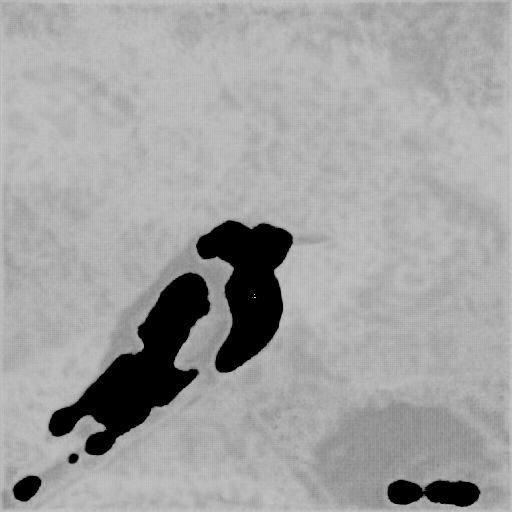

1


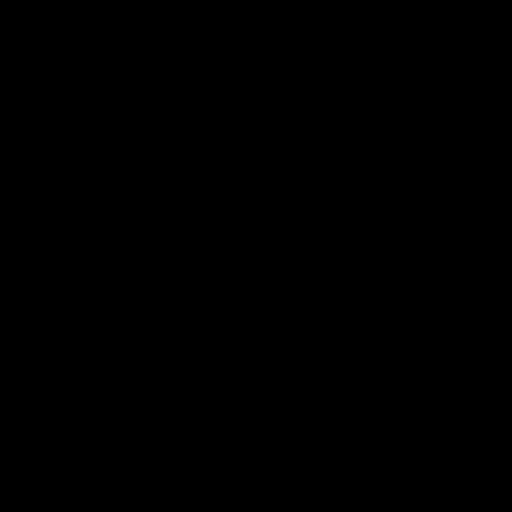

2


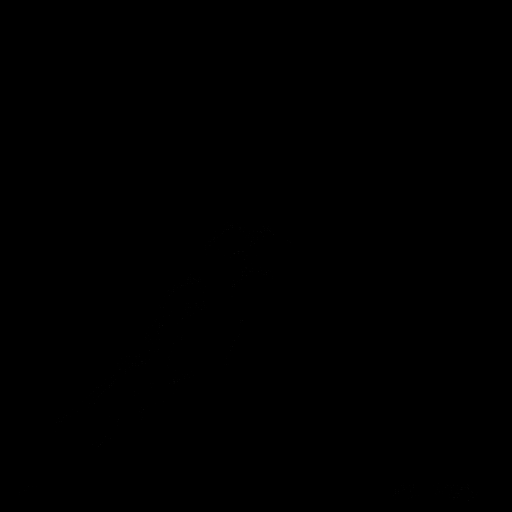

3


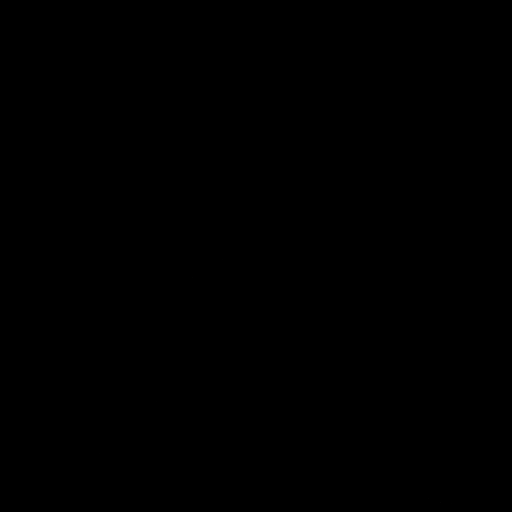

4


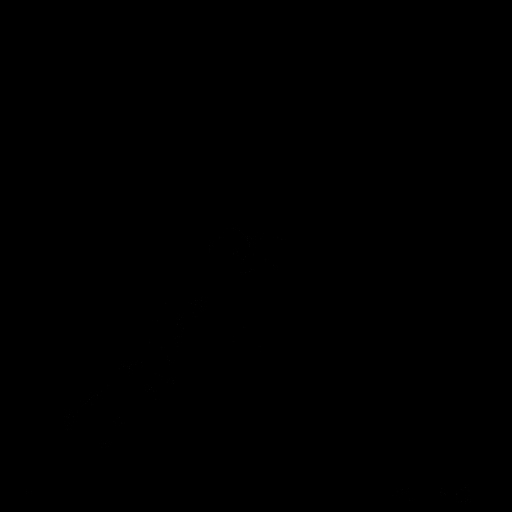

5


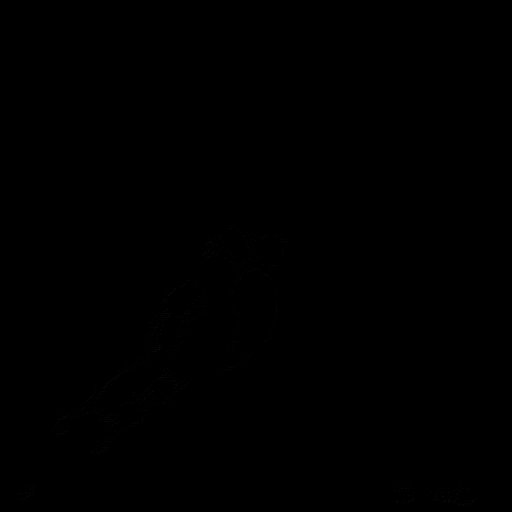

6


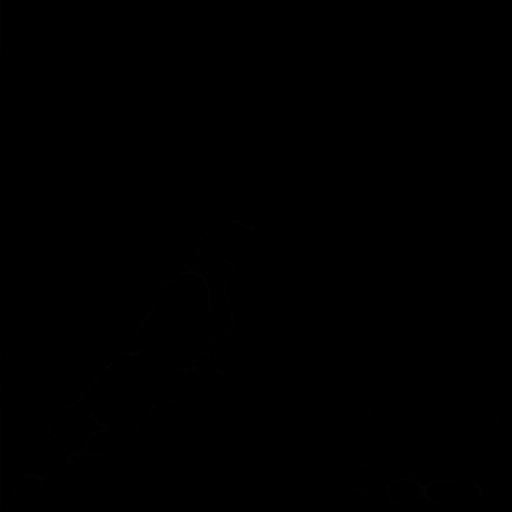

7


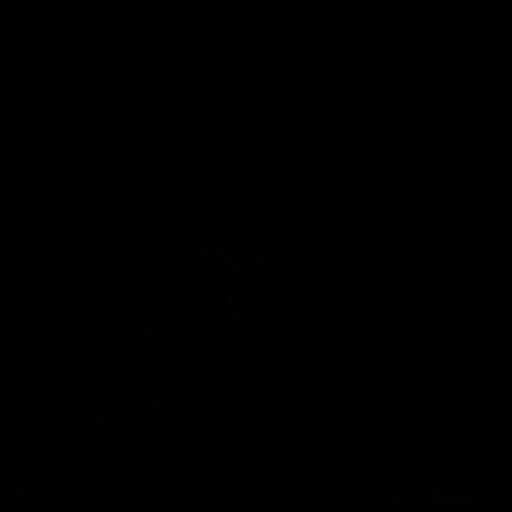

8


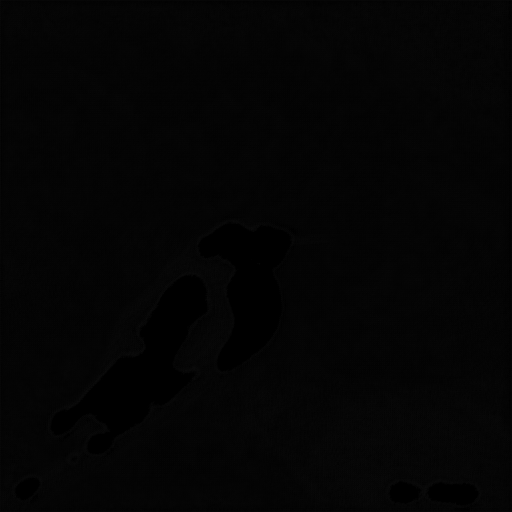

9


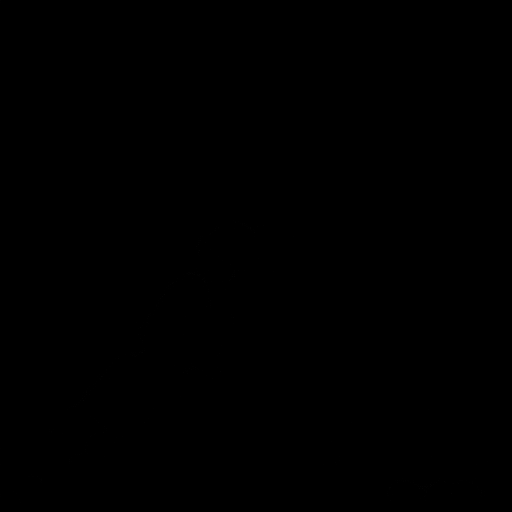

10


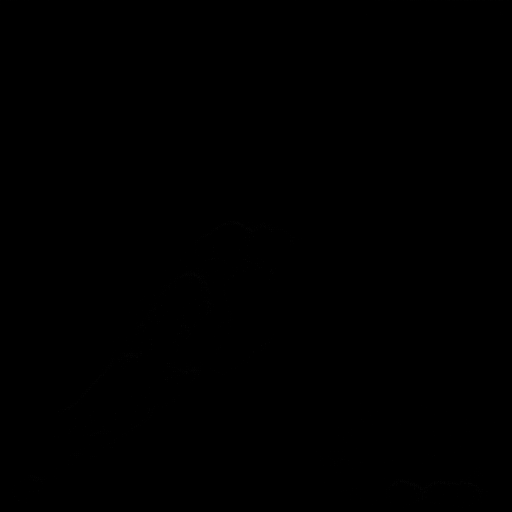

11


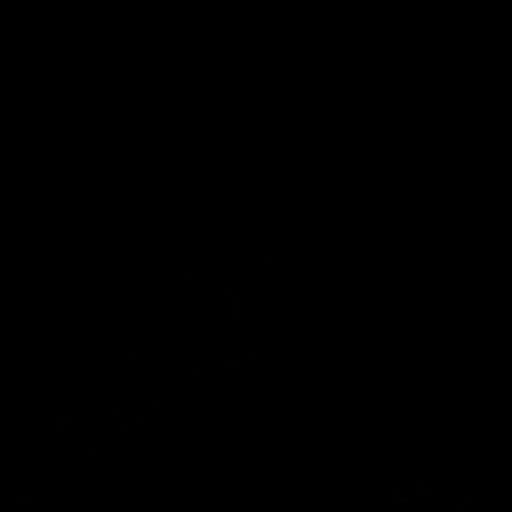

12


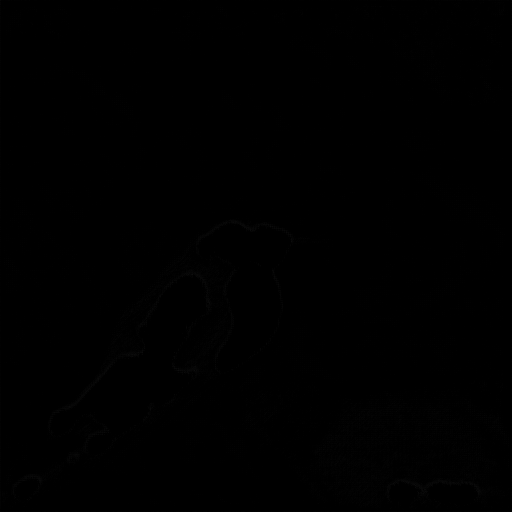

13


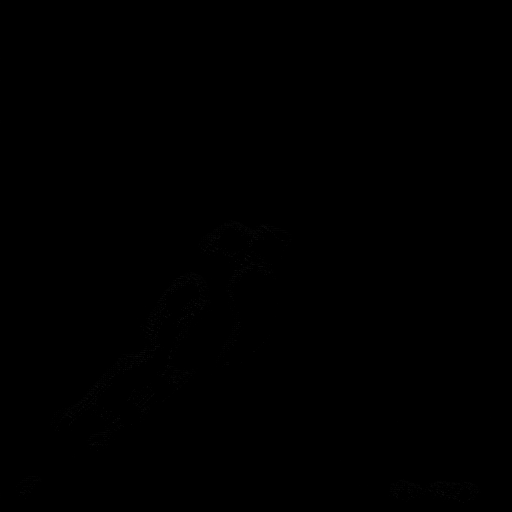

14


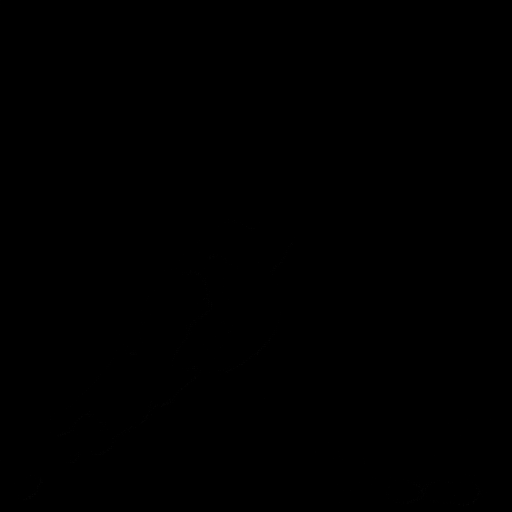

15


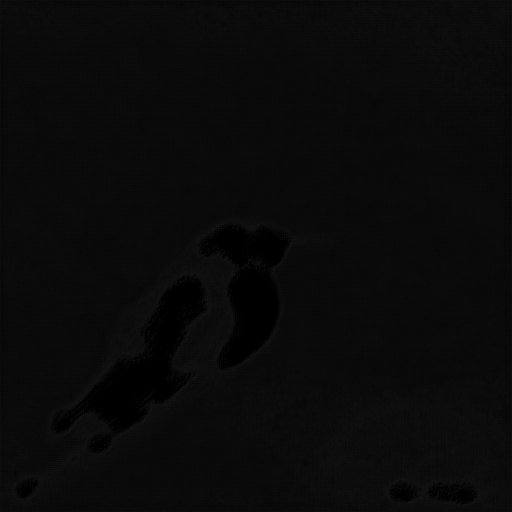

16


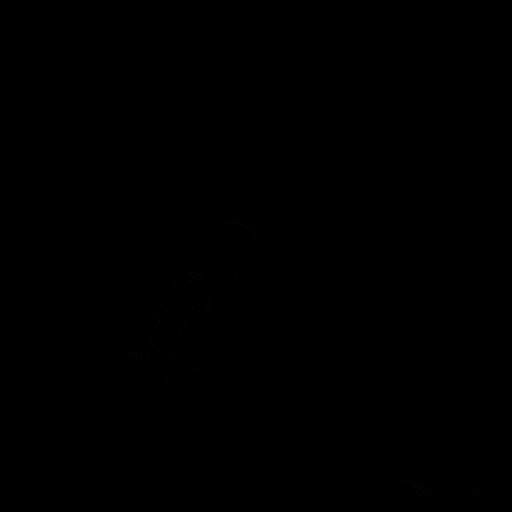

17


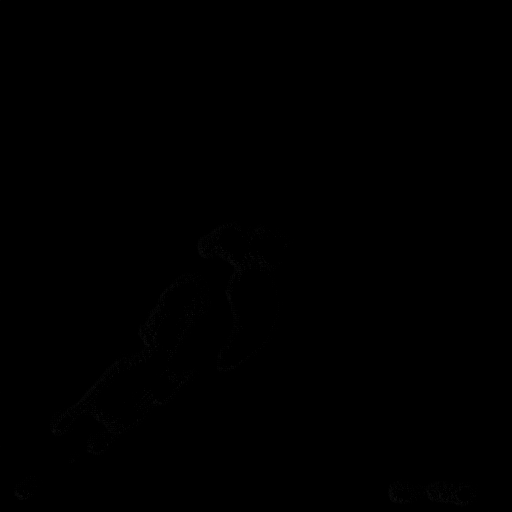

18


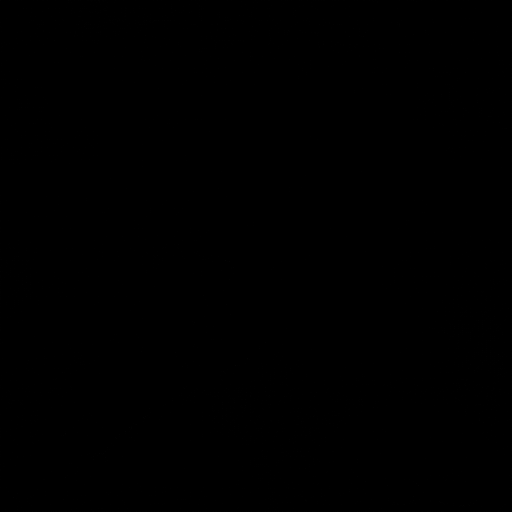

19


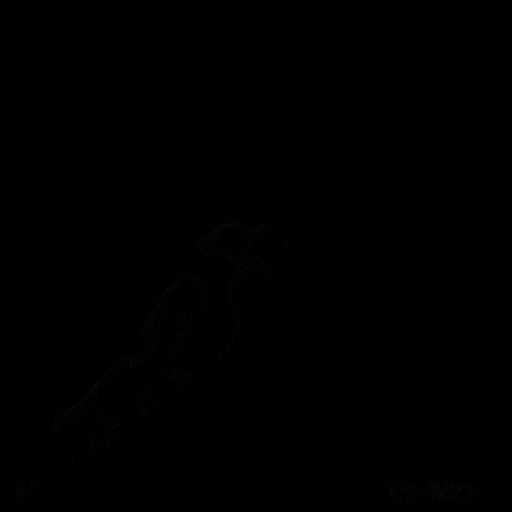

20


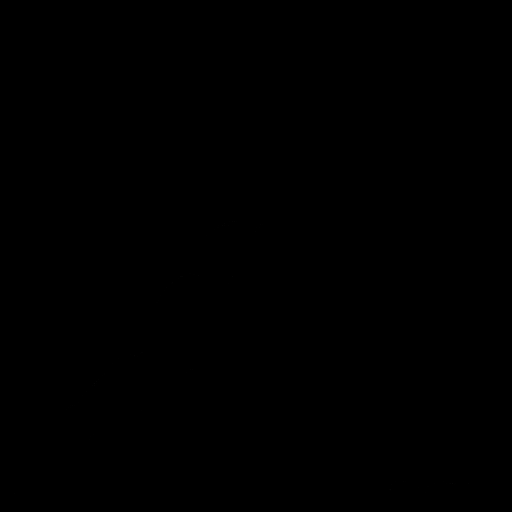

In [70]:
display(modelOutput.shape)

display(transforms.ToPILImage()(modelOutput[0][i] ))

for i in range(21):
    print(i)
    display(transforms.ToPILImage()(modelOutput[0][i] ))

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [12]:
import torch.optim as optim

# loss function
criterion = nn.MSELoss()


# optimizer variable
opt = optim.Adam(model.parameters())

#opt = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [13]:
def error():

    val = 0
    for inputs, targets in batches[:1]:
        inputs = inputs.cuda()
        targets = targets.cuda()

        outputs = model(inputs)
        val += criterion(outputs, targets)

        del inputs
        del targets
        torch.cuda.empty_cache() 
        
    print(val)

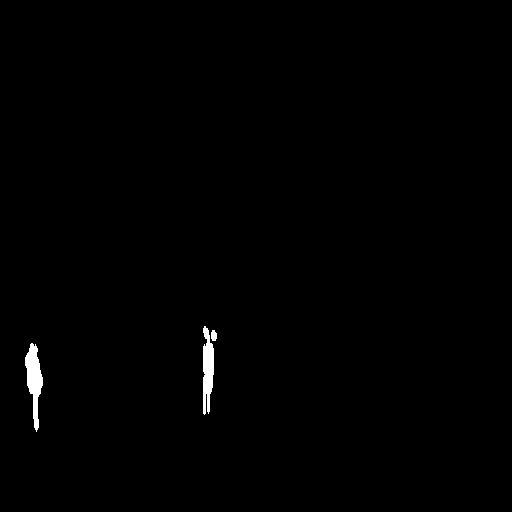

In [24]:

display(transforms.ToPILImage()(dst[0][1][15]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


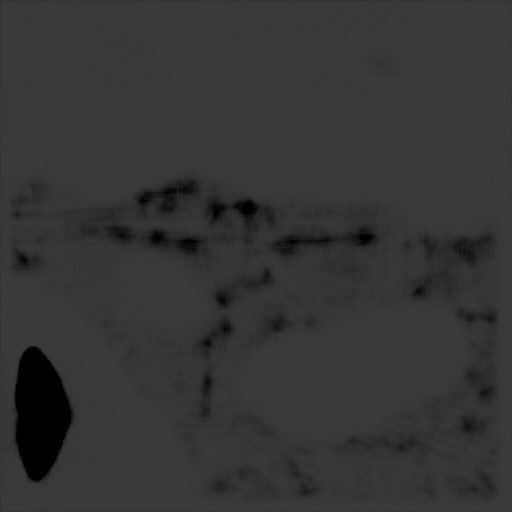

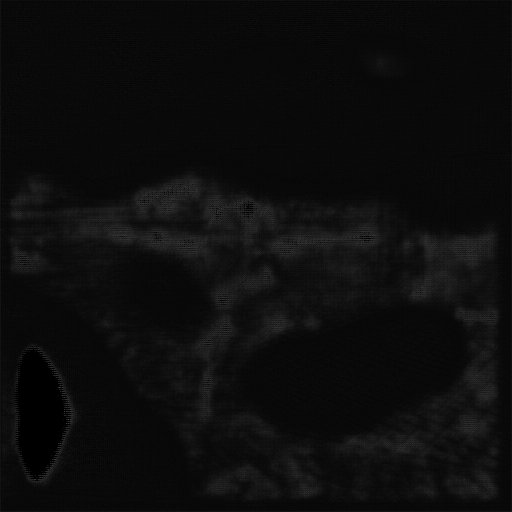

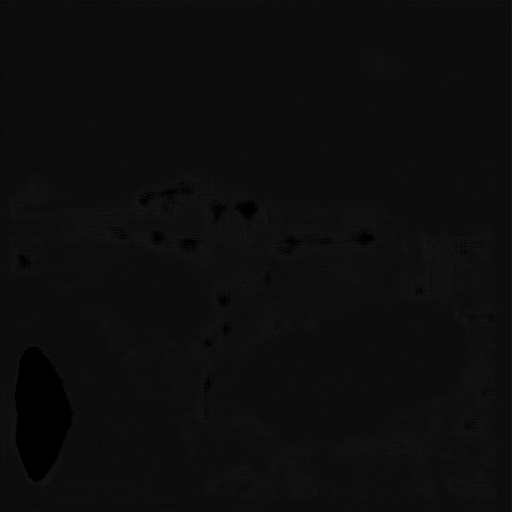

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


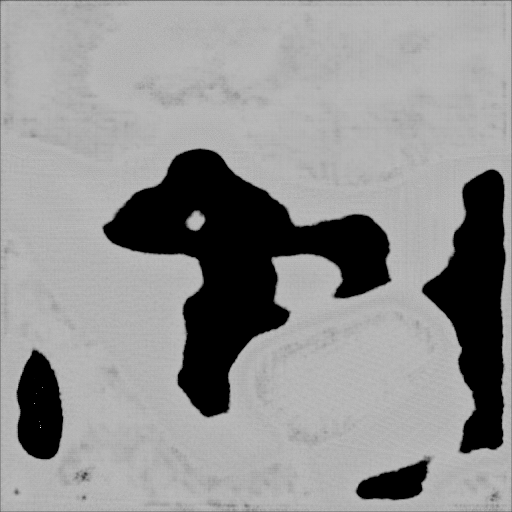

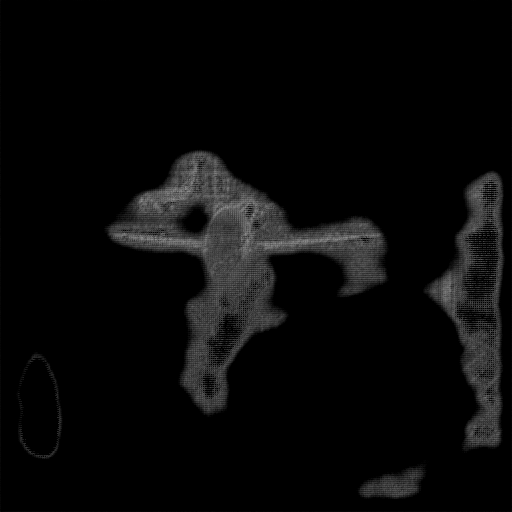

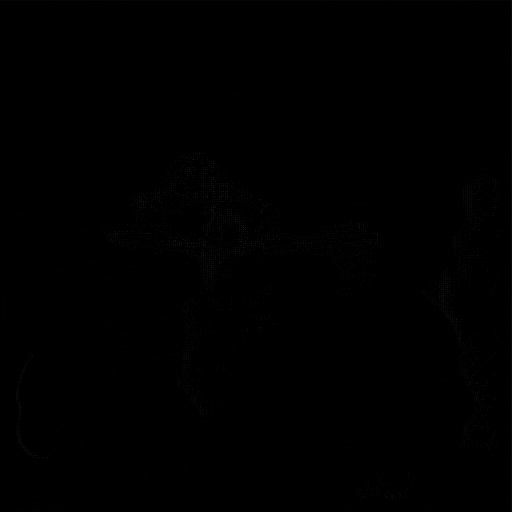

200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299


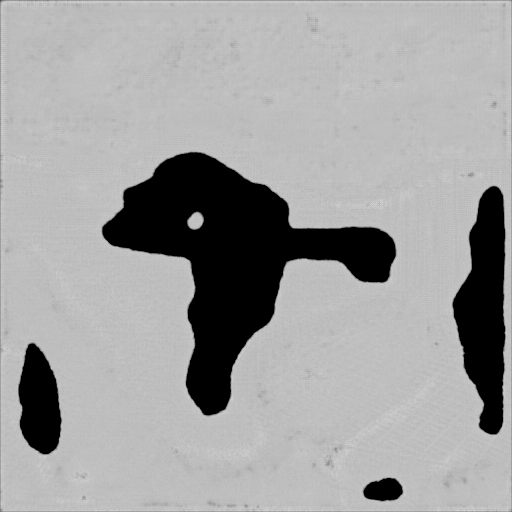

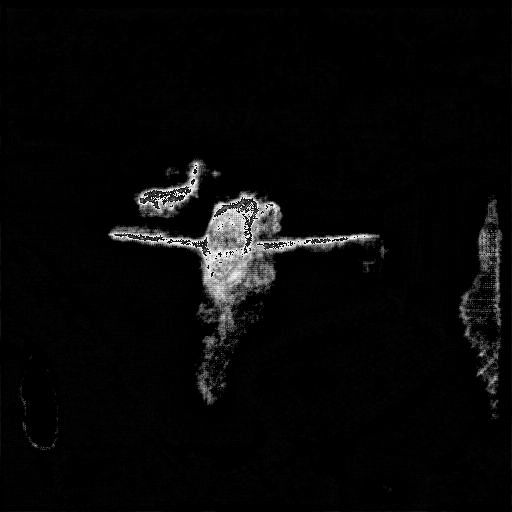

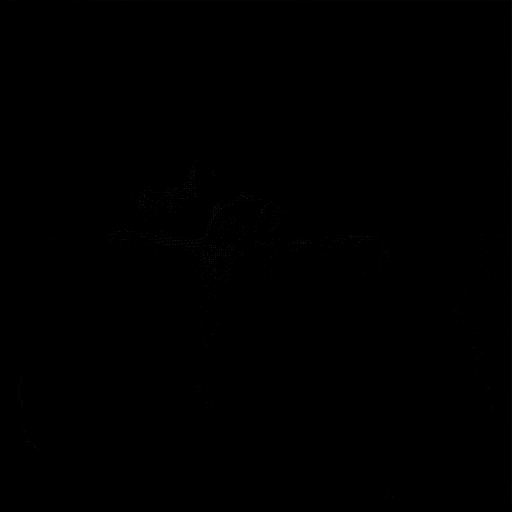

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399


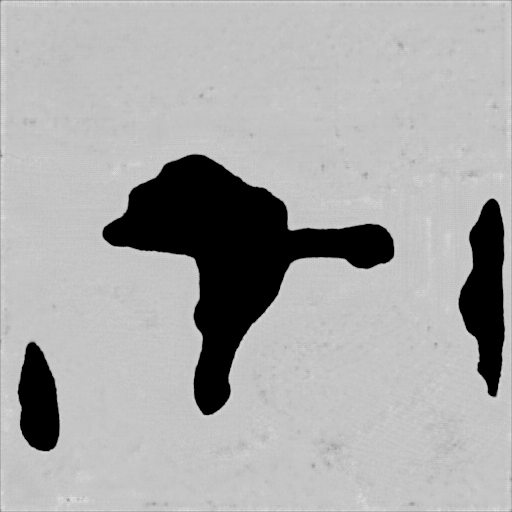

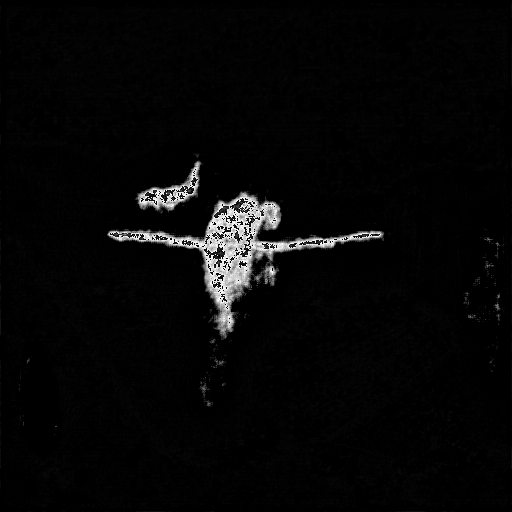

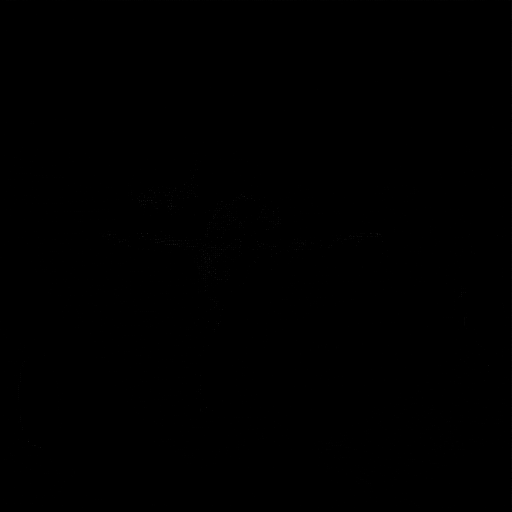

400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


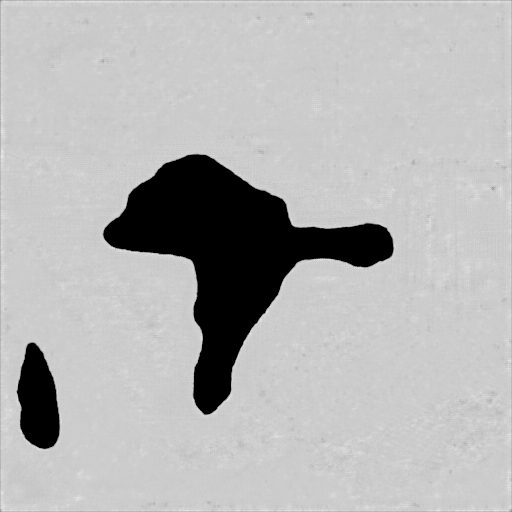

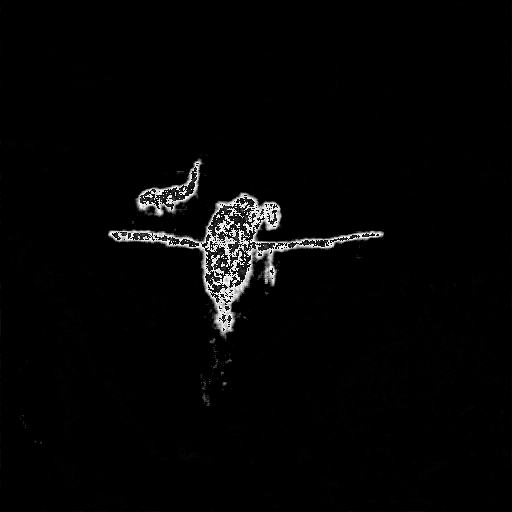

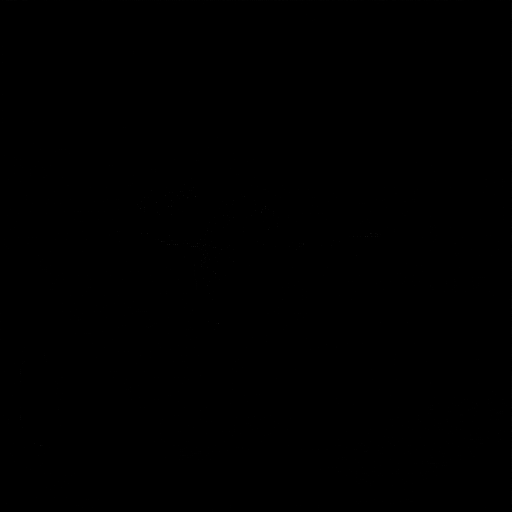

500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599


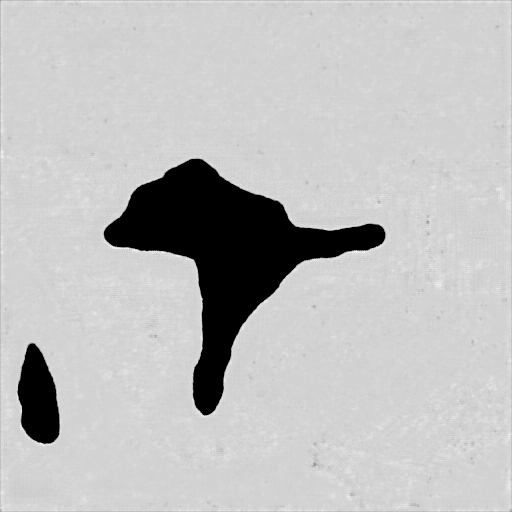

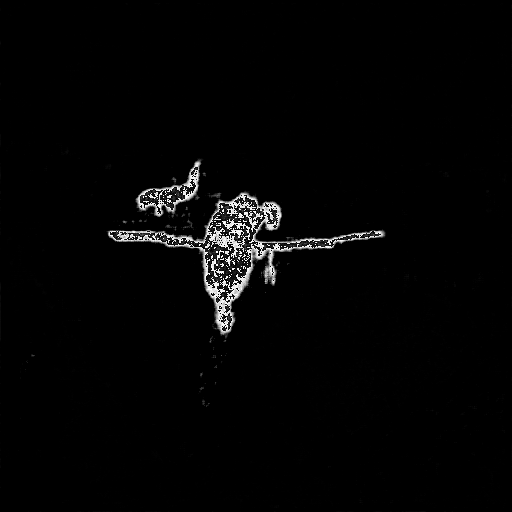

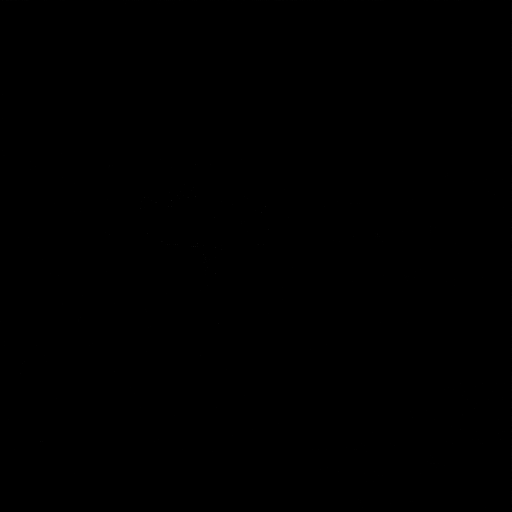

600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699


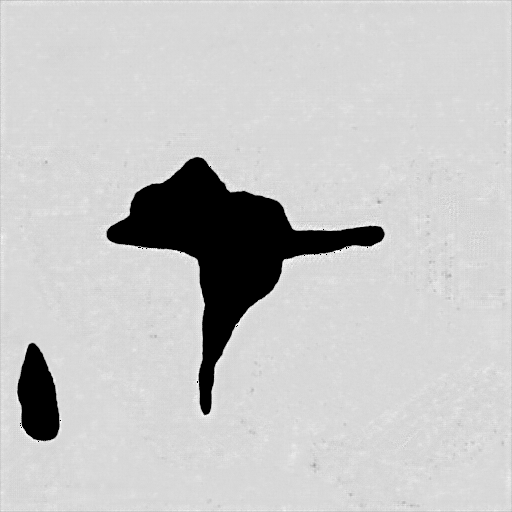

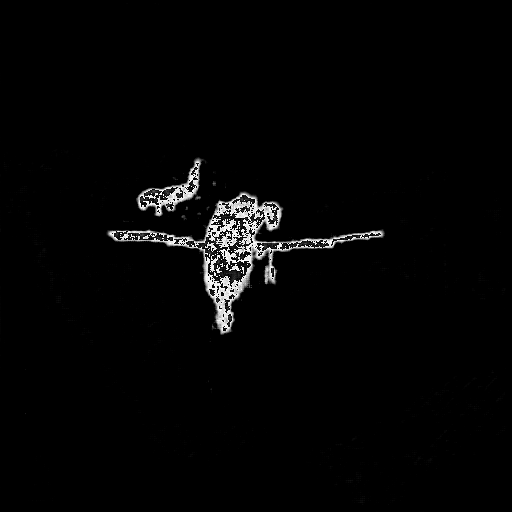

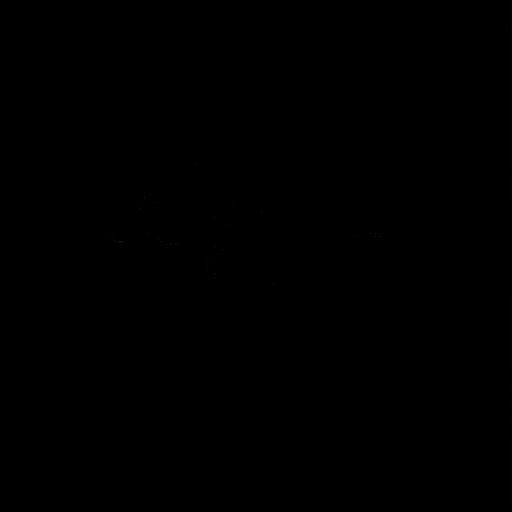

700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799


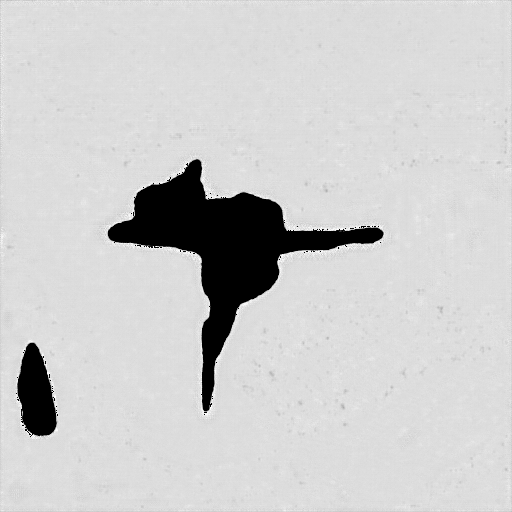

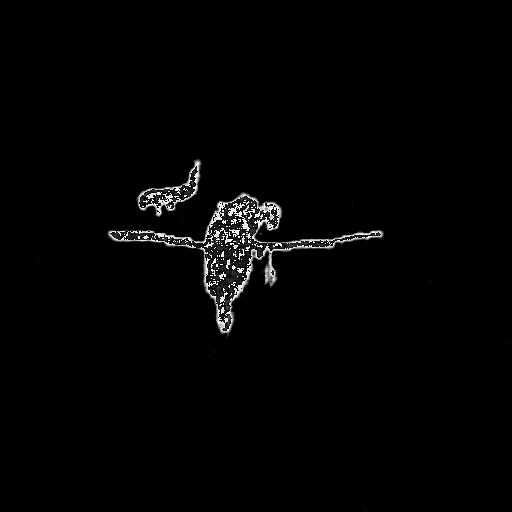

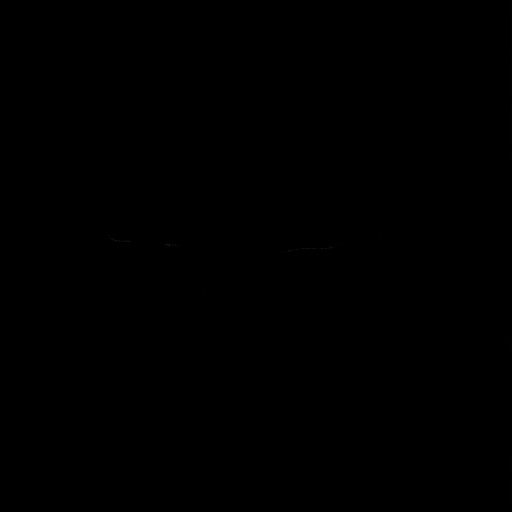

800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899


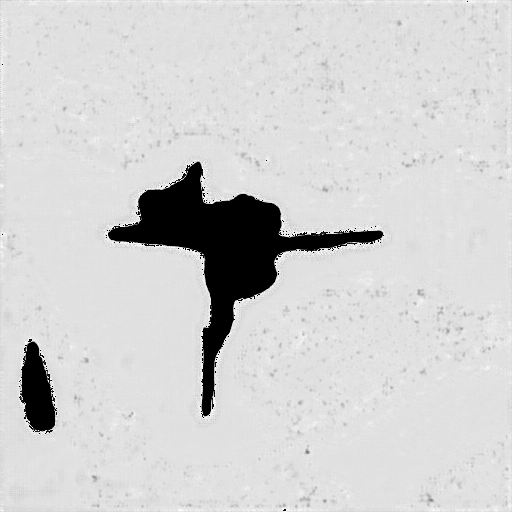

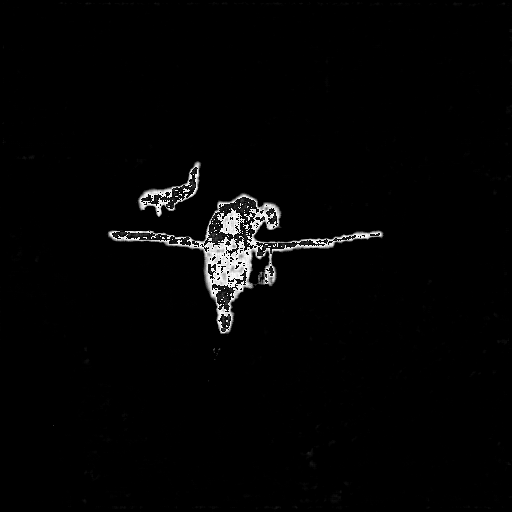

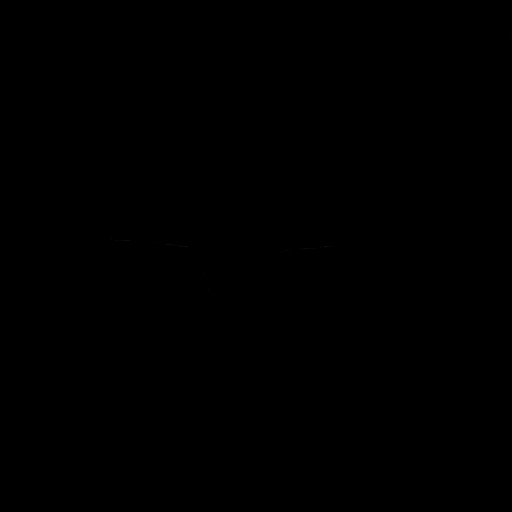

900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


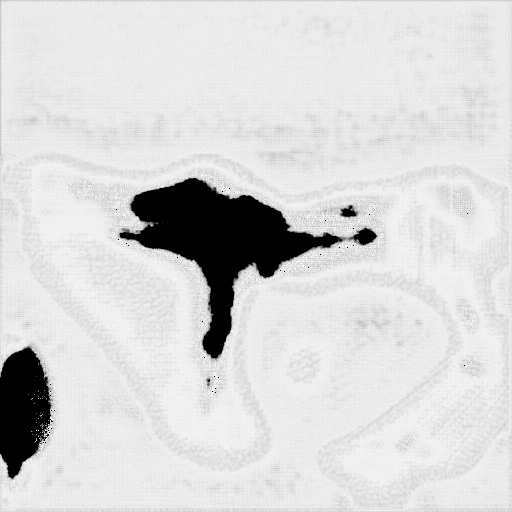

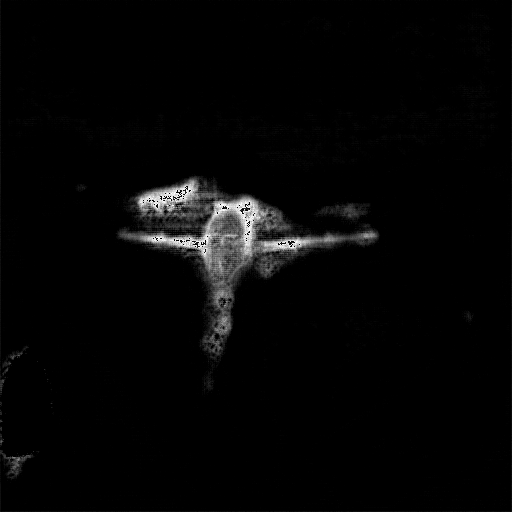

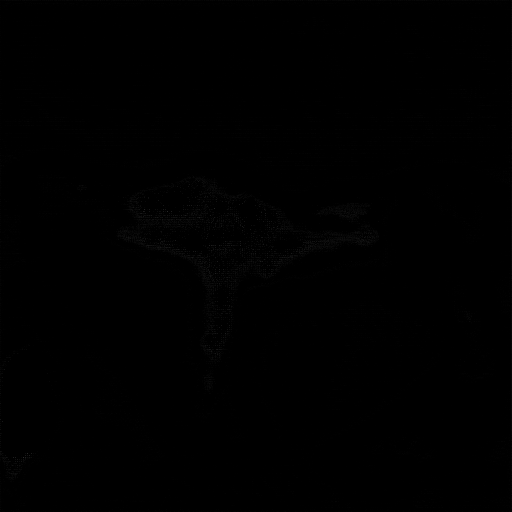

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099


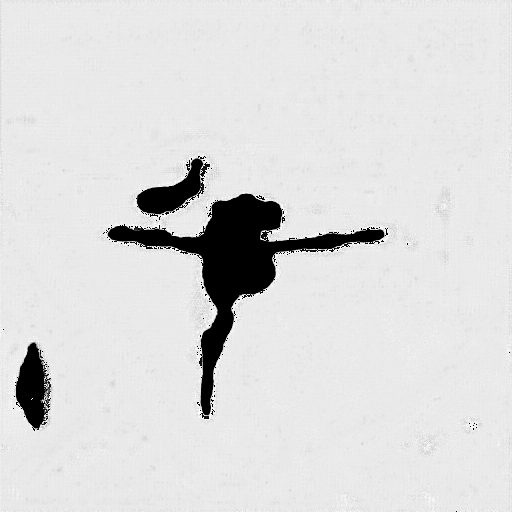

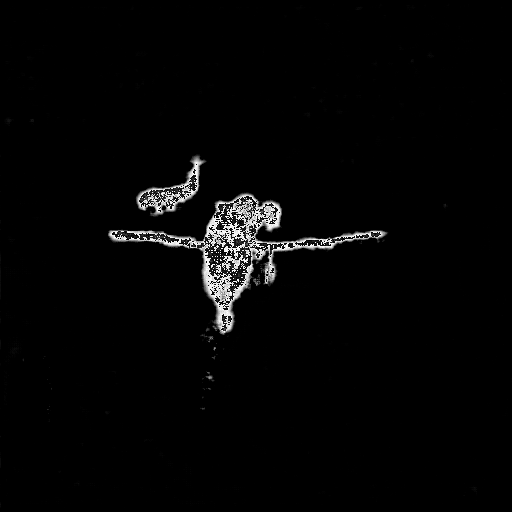

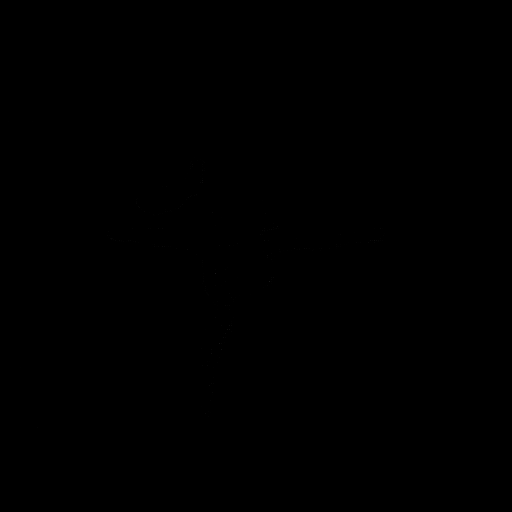

1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171
1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199


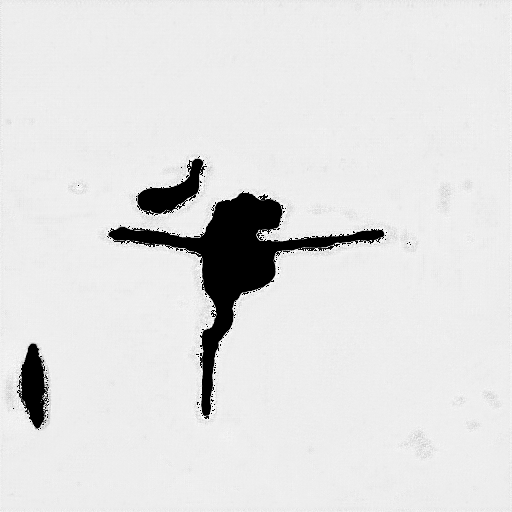

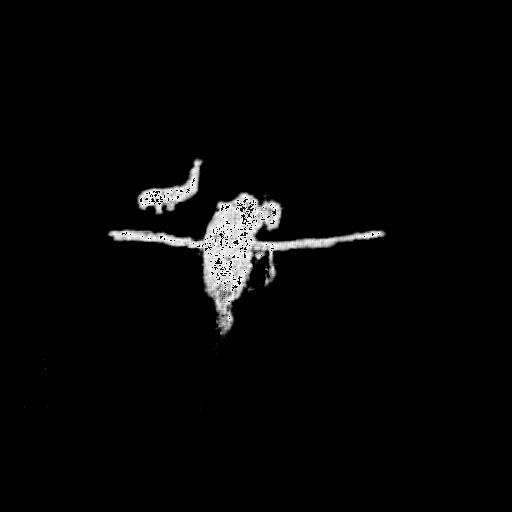

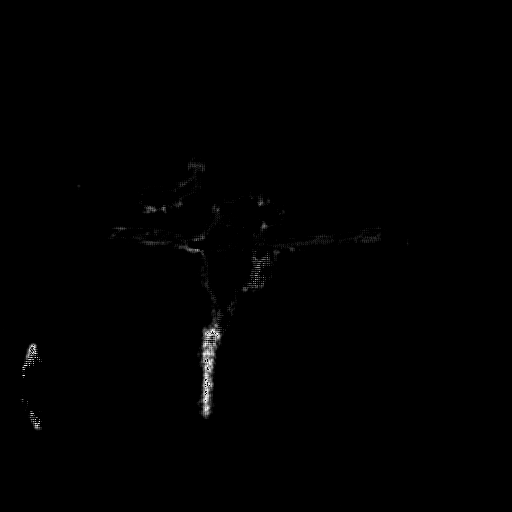

1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299


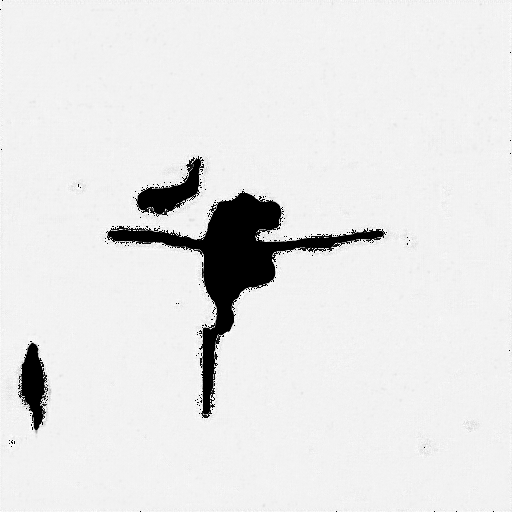

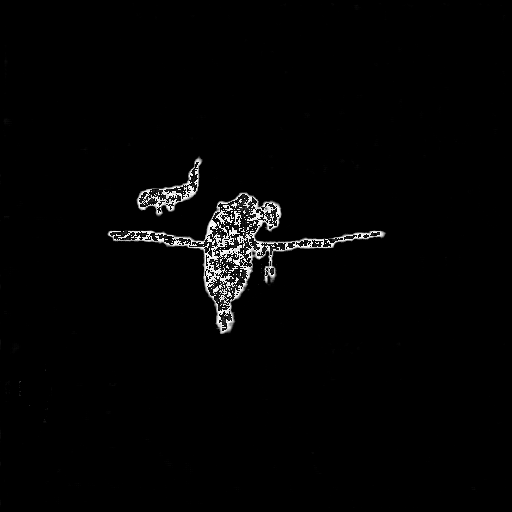

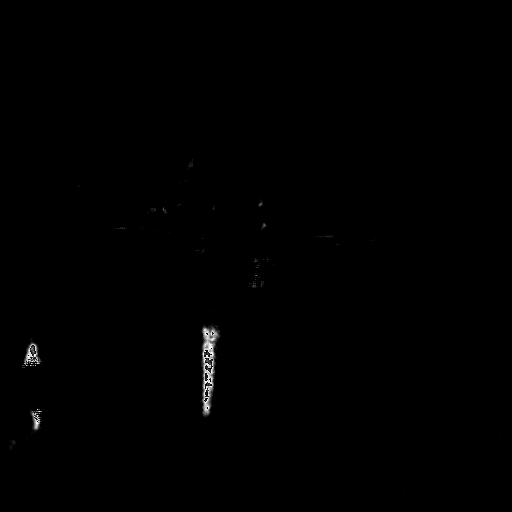

1300
1301
1302
1303
1304
1305
1306


In [ ]:
loss = None
i = 0

#error()
for _ in range(2000):
    
    
    for inputs, targets in trainloader:
        #if loss != None and i % 50 == 0:
        print(i)
        i+=1
        inputs = inputs.cuda()
        targets = targets.cuda()

        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        opt.step()  
        
        if i % 100 == 0:
            display(transforms.ToPILImage()(outputs[0][0].cpu() ))
            display(transforms.ToPILImage()(outputs[0][1].cpu() ))
            display(transforms.ToPILImage()(outputs[0][15].cpu() ))
            
        break
        
         
#error()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
def evaluate(ground_truth, predictions):
    
    return f1_score, auc_score, dice_coeeficient

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [2]:
import torch
torch.cuda.empty_cache() 

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [80]:
!shutdown /s